# **Sentiment Analys Aplikasi Bibit - Reksadana dan Obligasi**
## **M Wildan Nurohman**
## MC - 19

**IMPORT LIBRARY**

In [ ]:
!pip install google-play-scraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00


In [3]:

import pandas as pd  # untuk manipulasi dan analisis data
pd.options.mode.chained_assignment = None  # untuk menonaktifkan peringatan chaining
import numpy as np  # untuk komputasi numerik
seed = 0
np.random.seed(seed)  # mengatur seed untuk reproduktibilitas
import matplotlib.pyplot as plt  # untuk visualisasi data
import seaborn as sns  # untuk visualisasi data statistik, mengatur gaya visualisasi
import datetime as dt  # untuk manipulasi data waktu dan tanggal
import re  # untuk bekerja dengan ekspresi reguler
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords  # daftar kata-kata berhenti dalam teks
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # untuk mengubah teks menjadi vektor fitur
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  # untuk menghapus stop word dalam bahasa Indonesia
from wordcloud import WordCloud  # visualisasi berbentuk word cloud dari teks
import pickle
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

import csv
!pip install requests
import requests
import json

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**SCRAPPING DATASET**

In [ ]:
# mengambil review pengguna aplikasi bibit
scrapreview = reviews_all(
    'com.bibit.bibitid',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=130000
)

# membatasi scraping hanya 130.000 data ulasan
scrapreview_limited = scrapreview[:130000]

In [ ]:
with open('scrapping_bibit.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Menulis header CSV
    writer.writerow(['content','score'])

    # Menulis tiap ulasan ke dalam file CSV
    for review in scrapreview_limited:
        writer.writerow([
            review['content'],
            review.get('score', '')
        ])

**LOAD DATASET**

In [7]:
reviews_df = pd.read_csv('scrapping_bibit (1).csv')
reviews_df.head()

,content,score
0,kecewa.. fitur pencairan instan tiba-tiba tida...,1
1,5 bintang lah buat aplikasinya semuanya aman d...,5
2,tempat investasi paling mudah dipelajari. UI n...,4
3,"Kontrol investasi paling oke, menurutku. Secar...",4
4,"aku saya lupa pin, saat ingin rubah pin di sur...",1


In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  39644 non-null  object
 1   score    39644 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 619.6+ KB


In [9]:
# menghapus baris yg memiliki missing value dan disimpan ke dalam dataframe clean_df
clean_df = reviews_df.dropna()

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  39644 non-null  object
 1   score    39644 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 619.6+ KB


In [10]:
# menghapus data duplikat dari clean_df
clean_df = clean_df.drop_duplicates()

# menghitung jumlah baris dan kolom clean_df setelah proses menghapus duplikat
jumlah_baris_clean_df, jumlah_kolom_clean_df = clean_df.shape

# mencetak jumlah baris dan kolom setelah proses menghapus duplikat
print(f"Jumlah baris setelah menghapus duplikat: {jumlah_baris_clean_df}")

Jumlah baris setelah menghapus duplikat: 29858


In [ ]:
print(clean_df.isnull().sum())

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
appVersion              0
dtype: int64


**Preprocessing**

In [11]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # hapus mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r"http\S+", '', text) # hapus link
  text = re.sub(r'[0-9]+', '', text) # hapus numbers
  text = re.sub(r'[^\w\s]', '', text) # hapus numbers
  text = text.replace('\n', ' ') # ganti newline dengan spasi
  text = text.translate(str.maketrans('', '', string.punctuation)) # hapus tanda baca
  text = text.strip(' ') # hapus spasi diawal dan diakhir teks
  return text

def casefoldingText(text):
  text = text.lower()
  return text

def tokeninizeText(text):
  text = word_tokenize(text)
  return text

def filteringText(text):
  stop_words = set(stopwords.words('indonesian'))
  stop_woord2 = set(stopwords.words('english'))
  stop_words.update(stop_woord2)
  stop_words.update(['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo',
                      'kalo', 'amp', 'biar', 'bikin', 'bilang',
                      'gak', 'ga', 'sih', 'deh', 'loh', 'kah', 'gjls' 'ms', 'nya'])
  filtered_text = []
  for txt in text :
    if txt not in stop_words: # memeriksa apakah kata bukan stopword
      filtered_text.append(txt) # menambahkan kata yg bukan stopword ke filtered_text
  text = filtered_text
  return text

def stemmingText(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer() # membuat stemmer
  words = text.split()
  stemmed_words = [stemmer.stem(word) for word in words]
  text = ' '.join(stemmed_words) # menggabungkan kata yg telah di stemm menjadi 1 kalimat
  stemmed_text = []
  for txt in text:
    stemmed_text.append(stemmer.stem(txt))
  return stemmed_text

def toSentence(list_words):
  sentence = ' '.join(word for word in list_words)  # menggabungkan daftar kata menjadi satu kalimat
  return sentence

def fix_slangwords(text):
    words = text.split()  # membagi teks menjadi kata - kata
    fixed_words = []
    for word in words:
        if word.lower() in slang_words:  # memeriksa apakah kata tersebut adalah slang
            fixed_words.append(slang_words[word.lower()])  # mengganti slang menjadi standar
        else:
            fixed_words.append(word.lower())
    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [12]:
clean_df

,content,score
0,kecewa.. fitur pencairan instan tiba-tiba tida...,1
1,5 bintang lah buat aplikasinya semuanya aman d...,5
2,tempat investasi paling mudah dipelajari. UI n...,4
3,"Kontrol investasi paling oke, menurutku. Secar...",4
4,"aku saya lupa pin, saat ingin rubah pin di sur...",1
...,...,...
39638,Good....,5
39639,",👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎",1
39640,🤲🤲🤲,1
39641,🥝,1


In [13]:
url = 'https://raw.githubusercontent.com/wildannrr/bibitApp_sentiment-analiss/refs/heads/main/slang_words.json'

response = requests.get(url)

if response.status_code == 200:
    slang_words = response.json()
else:
    print("Gagal mengambil data dari URL")

In [18]:
clean_df['clean_text'] = clean_df['content'].apply(cleaningText) # membersihkan teks pada kolom 'Content' menggunakan fungsi cleaningText dan menyimpan hasilnya dalam kolom baru 'text_clean'
clean_df['casefolding_text'] = clean_df['clean_text'].apply(casefoldingText) # melakukan case folding pada teks yang sudah dibersihkan dan menyimpan hasilnya dalam kolom 'text_casefoldingText'
clean_df['slangwords_text'] = clean_df['casefolding_text'].apply(fix_slangwords) # Memperbaiki kata-kata slang dalam teks yang sudah di-casefold dan menyimpan hasilnya dalam kolom 'text_slangwords'
clean_df['tokenizing_text'] = clean_df['slangwords_text'].apply(tokeninizeText) # Melakukan tokenisasi pada teks yang sudah diperbaiki slangwords dan menyimpan hasilnya dalam kolom 'text_tokenizingText'
clean_df['stopword_text'] = clean_df['tokenizing_text'].apply(filteringText) # Melakukan filtering stopwords pada teks yang sudah di-tokenisasi dan menyimpan hasilnya dalam kolom 'text_stopword'
clean_df['text_akhir'] = clean_df['stopword_text'].apply(toSentence) # Menggabungkan kata-kata yang sudah difilter stopwords menjadi satu kalimat dan menyimpan hasilnya dalam kolom 'text_akhir'

clean_df.head()

,content,score,clean_text,casefolding_text,slangwords_text,tokenizing_text,stopword_text,text_akhir
0,kecewa.. fitur pencairan instan tiba-tiba tida...,1,kecewa fitur pencairan instan tibatiba tidak b...,kecewa fitur pencairan instan tibatiba tidak b...,kecewa fitur pencairan instan tibatiba tidak b...,"[kecewa, fitur, pencairan, instan, tibatiba, t...","[kecewa, fitur, pencairan, instan, tibatiba, p...",kecewa fitur pencairan instan tibatiba percaya...
1,5 bintang lah buat aplikasinya semuanya aman d...,5,bintang lah buat aplikasinya semuanya aman dan...,bintang lah buat aplikasinya semuanya aman dan...,bintang lah buat aplikasinya semuanya aman dan...,"[bintang, lah, buat, aplikasinya, semuanya, am...","[bintang, aplikasinya, aman, lancar, penarikan...",bintang aplikasinya aman lancar penarikan uang...
2,tempat investasi paling mudah dipelajari. UI n...,4,tempat investasi paling mudah dipelajari UI ny...,tempat investasi paling mudah dipelajari ui ny...,tempat investasi paling mudah dipelajari ui ny...,"[tempat, investasi, paling, mudah, dipelajari,...","[investasi, mudah, dipelajari, ui, nyaman, sis...",investasi mudah dipelajari ui nyaman sistem mu...
3,"Kontrol investasi paling oke, menurutku. Secar...",4,Kontrol investasi paling oke menurutku Secara ...,kontrol investasi paling oke menurutku secara ...,kontrol investasi paling baik menurutku secara...,"[kontrol, investasi, paling, baik, menurutku, ...","[kontrol, investasi, menurutku, ketersediaan, ...",kontrol investasi menurutku ketersediaan infor...
4,"aku saya lupa pin, saat ingin rubah pin di sur...",1,aku saya lupa pin saat ingin rubah pin di suru...,aku saya lupa pin saat ingin rubah pin di suru...,aku saya lupa pin saat ingin rubah pin di suru...,"[aku, saya, lupa, pin, saat, ingin, rubah, pin...","[lupa, pin, rubah, pin, suruh, masukan, ktp, k...",lupa pin rubah pin suruh masukan ktp kali coba...


In [19]:
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:  # jika status response adalah 200 artinya oke
        lines = response.text.strip().split('\n')  # memisahkan menjadi baris baris
        for line in lines:
            parts = line.split(',')  # memisahkan baris menjadi bagian-bagian berdasarkan koma
            word = ','.join(parts[:-1])  # menggabungkan bagian-bagian kecuali bagian terakhir
            score = parts[-1]  # mengambil bagian terakhir sebagai skor
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Gagal mengambil lexicon dari :  {url}")

    return lexicon

url_leksikon_positif = 'https://raw.githubusercontent.com/wildannrr/bibitApp_sentiment-analiss/refs/heads/main/positive_weighted.csv'
url_leksikon_negatif = 'https://raw.githubusercontent.com/wildannrr/bibitApp_sentiment-analiss/refs/heads/main/negative_weighted.csv'

positive = load_lexicon(url_leksikon_positif)
negative = load_lexicon(url_leksikon_negatif)

In [20]:
def sentiment_analysis_indonesia(text):
    score = 0  # Inisialisasi skor sentimen

    for word in text:
        if (word in positive):  # jika kata ada dalam leksikon positif
            score = score + positive[word]  # tambahkan skor positif kata tersebut ke skor total

    for word in text:
        if (word in negative):  # jika kata ada dalam leksikon negatif
            score = score + negative[word]  # tambahkan skor negatif kata tersebut ke skor total

    polarity = ''  # inisialisasi polaritas sentimen

    if (score > 0):
        polarity = 'positive'  # jika skor positif, polaritas positif
    elif (score < 0):
        polarity = 'negative'  # jika skor negatif,  polaritas negatif
    else:
        polarity = 'neutral'  # jika skor nol, polaritas netral

    return score, polarity  # mengembalikan skor sentimen dan polaritasnya

In [22]:
results = clean_df['stopword_text'].apply(sentiment_analysis_indonesia)
# Menggunakan fungsi sentiment_analysis_lexicon_indonesia untuk menghitung skor sentimen dan polaritas untuk setiap teks dalam kolom 'text_stopword'
# Hasilnya disimpan dalam variabel results sebagai objek Series yang berisi tuple (skor, polaritas)

results = list(zip(*results)) # Membongkar tuple hasil menjadi dua list terpisah: satu untuk skor sentimen dan satu lagi untuk polaritas

clean_df['polarity_score'] = results[0] # Menyimpan skor sentimen dari hasil analisis ke dalam kolom baru 'polarity_score' pada DataFrame clean_df

clean_df['polarity'] = results[1] # Menyimpan polaritas sentimen dari hasil analisis ke dalam kolom baru 'polarity' pada DataFrame clean_df

print(clean_df['polarity'].value_counts()) # Mencetak jumlah kemunculan setiap kategori polaritas sentimen ('positive', 'negative', 'neutral') dari kolom 'polarity' dalam DataFrame clean_df

# clean_df.to_csv('labeled_text.csv', encoding='utf8', index=False)
#unduh dataset yang sudah diberi label

polarity
neutral     14490
positive    13437
negative     1931
Name: count, dtype: int64


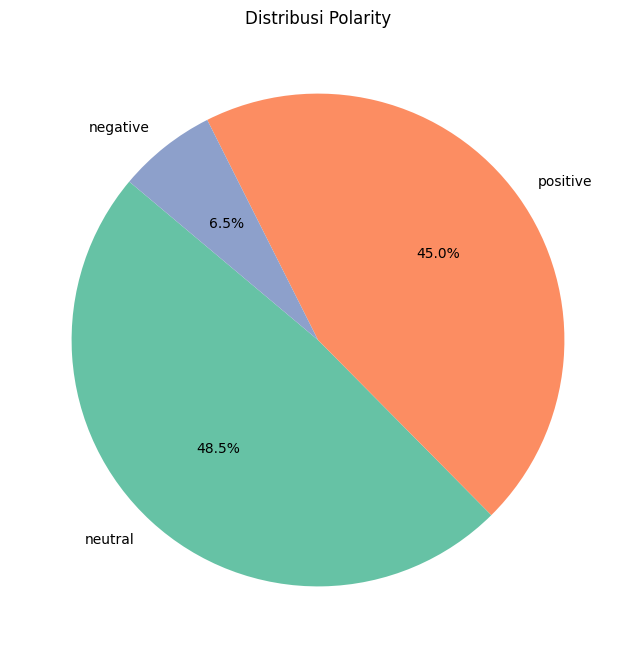

In [23]:
# Hitung jumlah masing-masing kategori polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Menampilkan diagram lingkaran
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribusi Polarity')
plt.show()

**EXPLORASI LABEL**

In [24]:
# membuat wordcloud untuk semua data
all_words = ' '.join([text for text in clean_df['text_akhir']])
all_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# wordcloud untuk data positif
positive_words = ' '.join([text for text in clean_df['text_akhir'][clean_df['polarity'] == 'positive']])
positive_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

# wordcloud untuk data negatif
negative_words = ' '.join([text for text in clean_df['text_akhir'][clean_df['polarity'] == 'negative']])
negative_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

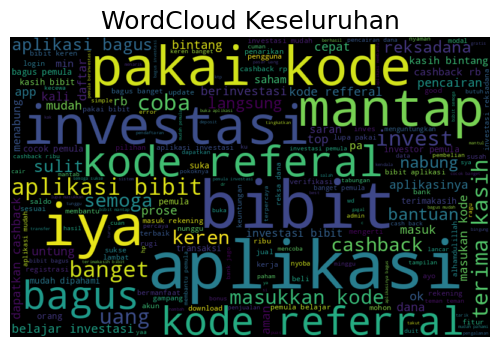

In [25]:
# wordCloud general
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Keseluruhan', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

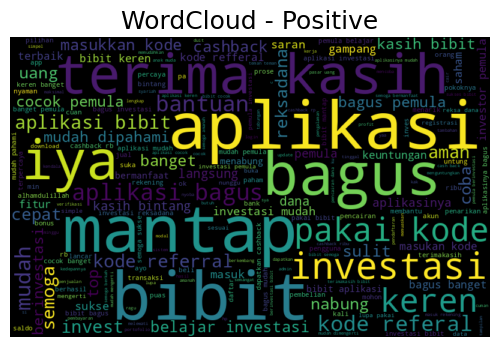

In [26]:
# menampilkan WordCloud Positive
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 2)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('WordCloud - Positive', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

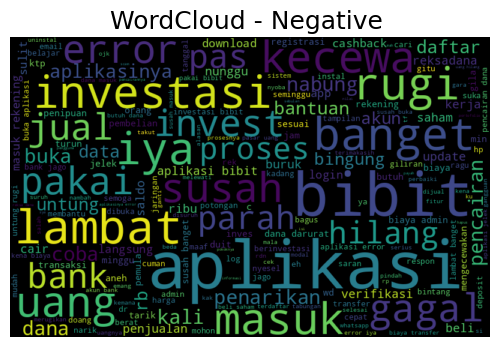

In [27]:
# Menampilkan WordCloud Negative
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('WordCloud - Negative ', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

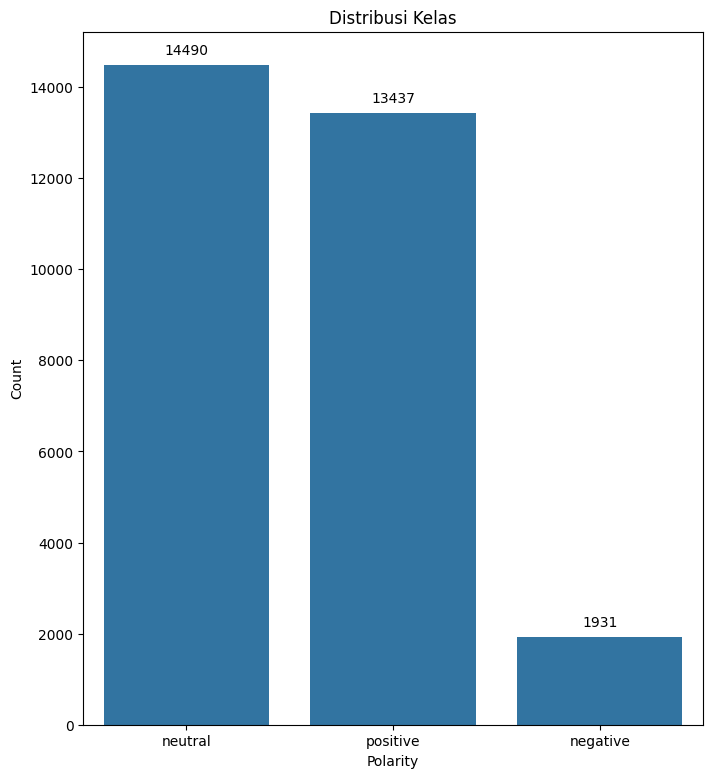

In [28]:
plt.figure(figsize=(8, 9))

# membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Distribusi Kelas')
plt.xlabel('Polarity')
plt.ylabel('Count')

# menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

plt.show()

**DATA SPLITTING & EKSTRAKSI FITUR DENGAN TF-IDF**

In [29]:
X = clean_df['text_akhir'] # Menyimpan nilai pada dataframe text_akhir ke variabel X
y = clean_df['polarity'] # Menyimpan nilai pada dataframe polarity ke variabel y

tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,admin,akun,alhamdulillah,aman,amanah,anak,aplikasi,aplikasinya,app,awam,...,transaksi,transfer,uang,untung,update,user,verifikasi,wd,ya,yaa
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.202223,0.0,0.0,0.000000,0.190729,0.0,0.0,...,0.0,0.0,0.37118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.187104,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.254278,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29853,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29854,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29855,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29856,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**MODELING**

In [30]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [31]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9715789473684211
Random Forest - accuracy_test: 0.9215226613083277


In [32]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9252153110047847
Logistic Regression - accuracy_test: 0.9240901987050681


In [33]:
from sklearn.tree import DecisionTreeClassifier

# Membuat objek model Decision Tree
decision_tree = DecisionTreeClassifier()

# Melatih model Decision Tree pada data pelatihan
decision_tree.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi model Decision Tree
accuracy_train_dt = accuracy_score(y_pred_train_dt, y_train)
accuracy_test_dt = accuracy_score(y_pred_test_dt, y_test)

# Menampilkan akurasi
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Decision Tree - accuracy_train: 0.9715789473684211
Decision Tree - accuracy_test: 0.9063407010493414


In [34]:
from sklearn.naive_bayes import BernoulliNB

# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)

Naive Bayes - accuracy_train: 0.8728708133971292
Naive Bayes - accuracy_test: 0.8706184416164322


In [35]:
print('Naive Bayes - accuracy_train:', accuracy_train_nb)
print('Naive Bayes - accuracy_test:', accuracy_test_nb)
print()
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)
print()
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)
print()
print('Decision Tree - accuracy_train:', accuracy_train_dt)
print('Decision Tree - accuracy_test:', accuracy_test_dt)

Naive Bayes - accuracy_train: 0.8728708133971292
Naive Bayes - accuracy_test: 0.8706184416164322

Random Forest - accuracy_train: 0.9715789473684211
Random Forest - accuracy_test: 0.9215226613083277

Logistic Regression - accuracy_train: 0.9252153110047847
Logistic Regression - accuracy_test: 0.9240901987050681

Decision Tree - accuracy_train: 0.9715789473684211
Decision Tree - accuracy_test: 0.9063407010493414


In [36]:
# simpan model random forest
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

# simpan tfid
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [37]:
def preprocess_text(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    text = tokeninizeText(text)
    text = filteringText(text)
    text = toSentence(text)
    return text

def prediksi_sentimen_kalimat_baru(review_baru, tfidf, svm):
    # melakukan preprocessing pada kalimat baru
    review_baru_cleaned = cleaningText(review_baru)
    review_baru_casefolded = casefoldingText(review_baru_cleaned)
    review_baru_slangfixed = fix_slangwords(review_baru_casefolded)
    review_baru_tokenized = tokeninizeText(review_baru_slangfixed)
    review_baru_filtered = filteringText(review_baru_tokenized)
    review_baru_final = toSentence(review_baru_filtered)

    # menggunakan objek tfidf yang sudah di-fit dari pelatihan sebelumnya
    X_review_baru = tfidf.transform([review_baru_final])

    # convert sparse matrix to dense array
    X_review_baru = X_review_baru.toarray()

    # memperoleh prediksi sentimen review baru menggunakan model terbaik
    prediksi_sentimen = svm.predict(X_review_baru)

    # menampilkan hasil prediksi
    if prediksi_sentimen[0] == 'positive':
        hasil = "Sentimen review adalah POSITIF."
    elif prediksi_sentimen[0] == 'negative':
        hasil = "Sentimen review adalah NEGATIF."
    else:
        hasil = "Sentimen review adalah NETRAL."

    return hasil

In [38]:
review_baru = "aplikasi jelek, gagal login mulu"
prediksi_sentimen_kalimat_baru(review_baru, tfidf,random_forest )

'Sentimen review adalah NEGATIF.'

In [39]:
review_baru = "keren banget, fitur lancar, investasi mudah"
prediksi_sentimen_kalimat_baru(review_baru, tfidf,random_forest )

'Sentimen review adalah POSITIF.'

In [40]:
review_baru = "lumayan lah ya"
prediksi_sentimen_kalimat_baru(review_baru, tfidf, random_forest)

'Sentimen review adalah NETRAL.'

In [ ]:
!pip freeze > requirement.txt